In [1]:
import os
import sys
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [188]:
import tensorflow.keras
import tensorflow as tf
import scipy as sp
import tensorflow as tf
import platform
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO
from PIL import Image
import cv2
from tensorflow.keras import models
import random as rand
import pandas as pd
import glob
from numpy import linalg as LA
from operator import itemgetter
import matplotlib.gridspec as gridspec


In [3]:
print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")

Python Platform: Linux-5.19.0-45-generic-x86_64-with-glibc2.31
Tensor Flow Version: 2.9.2
Keras Version: 2.9.0

Python 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]


In [4]:
# tf.debugging.set_log_device_placement(False)
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

1 Physical GPUs, 1 Logical GPUs


In [5]:
gpus = tf.config.list_physical_devices('GPU')
print("GPU Resources Available:\n\t",gpus)

# getting rid of the warning messages about optimizer graph
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

GPU Resources Available:
	 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Helper Functions

In [6]:
def load_image_as_array(url, size=(150, 150), local_path=False):
    img = None
    if local_path:
        img = Image.open(url)
    else:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
    img = img.resize(size)
    return np.array(img).astype(float)

In [7]:
def prepare_image_for_display(img, norm_type='max'):
    if norm_type == 'max':
        # min/max scaling, best for regular images
        new_img = (img - img.min()) / (img.max()-img.min())
    else:
        # std scaling, best when we are unsure about large outliers
        new_img = ((img - img.mean()) / (img.std() +1e-3))*0.15 + 0.5
        
    new_img *= 255
    new_img = np.clip(new_img, 0, 255)
    
    if len(new_img.shape)>3:
        new_img = np.squeeze(new_img)
        
    return new_img.astype('uint8')

# Convolutional Neural Network Selected

**Model Chosen** VGG19

**Explain the model**

**Why was VGG19 Chosen**

In [8]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions

## Classify few images with the pre-trained network

In [9]:
vgg19_classify_model = VGG19(weights='imagenet')

In [10]:
# set VGG to be frozen
for layer in vgg19_classify_model.layers:
    layer.trainable = False
    
vgg19_classify_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
labels_df = pd.read_csv('classes_in_imagenet_2.txt', delim_whitespace=True)

In [12]:
def predict_images(folder, model, decorder, processor, size=(224,224)):
    for image_path in os.listdir(folder):
        path = os.path.join(folder, image_path)
        img = load_image_as_array(path, size=size, local_path=True)
        x = np.expand_dims(img, axis=0)

        preds = model.predict(x)
        top3_decoded_predictions = decorder(preds, top=3)[0]
        print('Predicted:', top3_decoded_predictions)

        # We add a dimension to transform our array into a "batch"
        # of size (1, 224, 224, 3)
        plt.figure(figsize=(10,10))
        plt.subplot(1,3,1)
        plt.imshow(prepare_image_for_display(x))
        plt.title('Image before processing')

        # Finally we preprocess the batch
        # (this normalizes according to VGG training)
        x = processor(x)

        plt.subplot(1,3,2)
        plt.imshow(prepare_image_for_display(x))
        plt.title('Image after VGG pre-processing')


        plt.subplot(1,3,3)
        plt.bar(*zip(*[x[1:] for x in top3_decoded_predictions]))
        plt.title('Top 3 Predictions for {}'.format(image_path))

        plt.show()

1/1 [==============================] - 3s 3s/step
Predicted: [('n02105162', 'malinois', 0.6777668), ('n02105412', 'kelpie', 0.21555361), ('n02106662', 'German_shepherd', 0.0844141)]


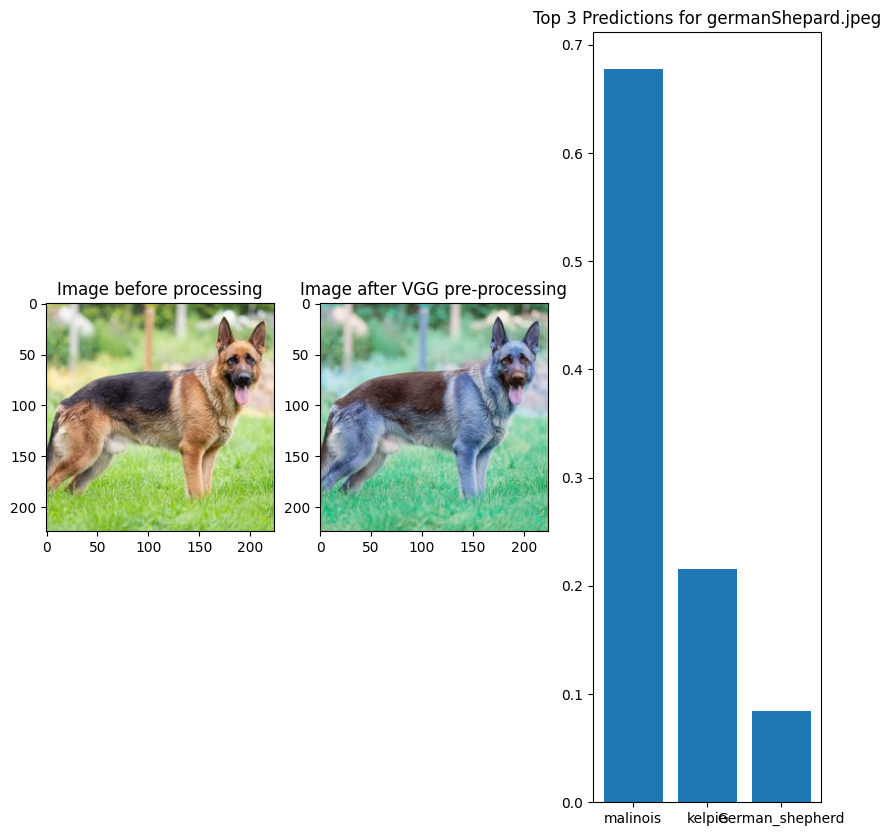

1/1 [==============================] - 0s 18ms/step
Predicted: [('n06359193', 'web_site', 0.15004303), ('n03196217', 'digital_clock', 0.0784127), ('n03787032', 'mortarboard', 0.055985663)]


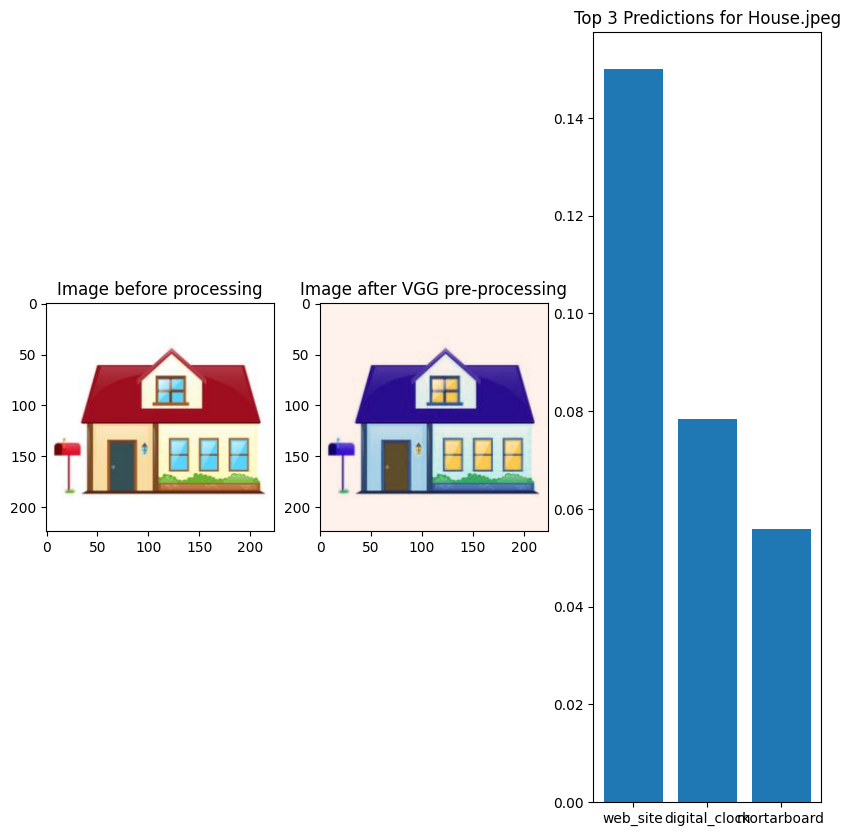

1/1 [==============================] - 0s 17ms/step
Predicted: [('n02484975', 'guenon', 0.4412941), ('n02487347', 'macaque', 0.37745667), ('n02488291', 'langur', 0.07112928)]


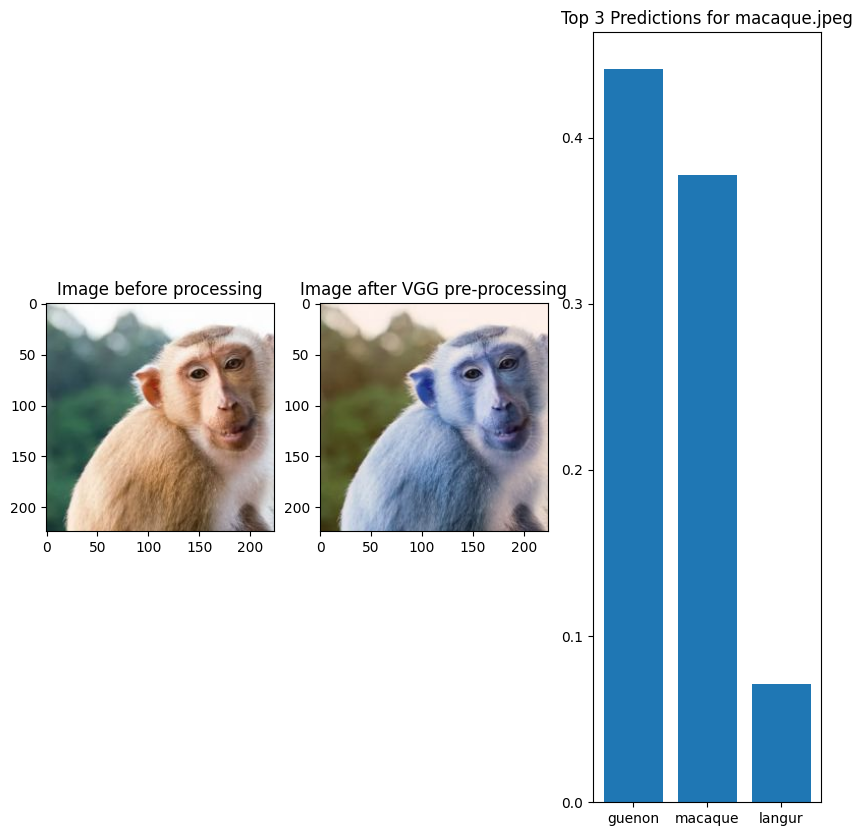

1/1 [==============================] - 0s 16ms/step
Predicted: [('n02105412', 'kelpie', 0.75235474), ('n02093256', 'Staffordshire_bullterrier', 0.045513425), ('n02109961', 'Eskimo_dog', 0.04097242)]


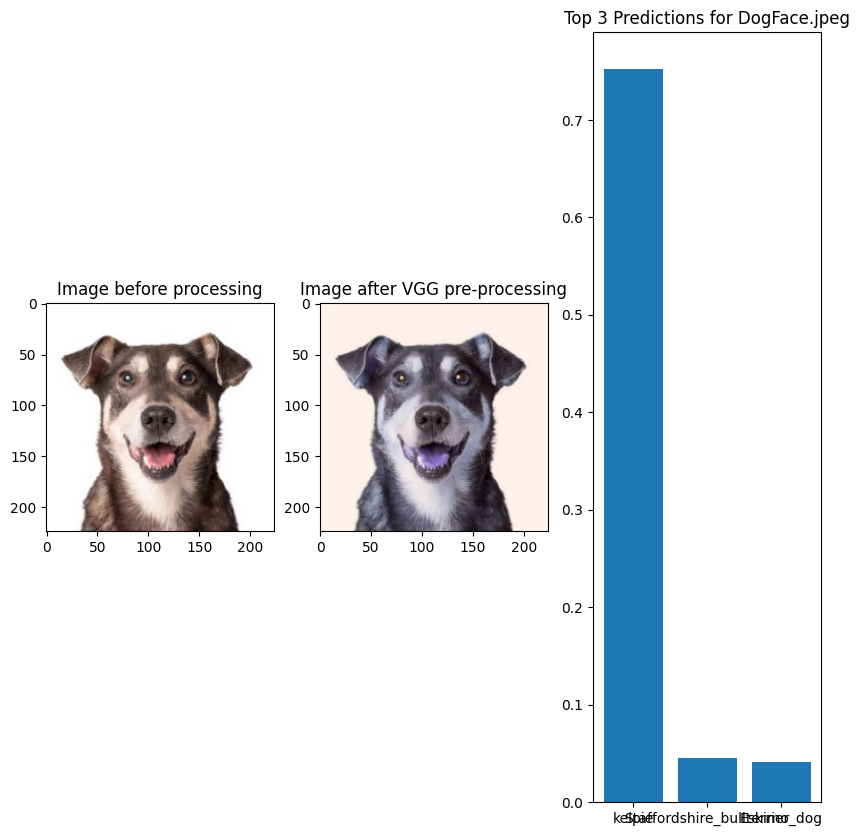

In [13]:
predict_images("/notebooks/Lab3/test_images",vgg19_classify_model, decode_predictions, preprocess_input)

**Notes**

# Select a Multi-Channel Filter in a layer to analyze as part of a circuit

In [14]:
layer_name = 'block4_conv3'
previous_layer_name = 'block4_conv2'
filter_index = 67 

## Find an input image that maximally excites the chosen multi-channel filter

In [15]:
# Load the pre-trained VGG16 model
vgg19_model = VGG19(weights='imagenet', include_top=False, input_tensor=None)

# set VGG to be frozen
for layer in vgg19_model.layers:
    layer.trainable = False


In [16]:
vgg19_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [17]:
def print_layer_filter_info(model, layer_name, filter_index):
    keras_layer = model.get_layer(layer_name)
    layer_output = keras_layer.output
    weights_list = keras_layer.get_weights() # list of filter, the biases
    filters = weights_list[0]
    biases = weights_list[1]

    # print out some specifics of how the filter is saved
    print('{} activation size is '.format(layer_name), layer_output.get_shape(), '(batch x H x W x filter)')
    print('{} filters is of shape'.format(layer_name),filters.shape, '...(k x k x channels x filters)')
    print('{} biases is of shape'.format(layer_name),biases.shape)

    idx = 67
    print('one filter in {} is '.format(layer_name), filters[:,:,:,idx].shape )
    channel = 2
    print('one channel in the the filter is', filters[:,:,channel,idx].shape)
    print('The weights of that channel in the filter are:\n', filters[:,:,channel,idx])
    print('The bias of the filter is:',biases[idx])

In [ ]:
print_layer_filter_info(vgg19_model, 'block2_conv2', 127)

block4_conv3 activation size is  (None, None, None, 512) (batch x H x W x filter)
block4_conv3 filters is of shape (3, 3, 512, 512) ...(k x k x channels x filters)
block4_conv3 biases is of shape (512,)
one filter in block4_conv3 is  (3, 3, 512)
one channel in the the filter is (3, 3)
The weights of that channel in the filter are:
 [[ 0.00332867  0.00022855 -0.00136682]
 [ 0.00198995 -0.00136602 -0.00109394]
 [ 0.00031633  0.00138619  0.00150212]]
The bias of the filter is: 0.005055893


In [225]:
def generate_pattern(model, processor, layer_name, filter_index, size=224, epochs=40):
    # Build a model that outputs the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    # Isolate the output 
    new_model = models.Model(inputs=model.input, outputs=layer_output)
    # We start from a gray image with some uniform noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    I_start = tf.Variable(input_img_data, name='image_var', dtype = 'float64')
    I = processor(I_start) # only process once
    # Run gradient ascent for 40 steps
    eta = 1.
    for i in range(epochs):
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(I)
            # get variable to maximize 
            model_vals = new_model(I) 
            filter_output = tf.reduce_mean(model_vals[:, :, :, filter_index])

        # Compute the gradient of the input picture w.r.t. this loss
        # add this operation input to maximize
        grad_fn = tape.gradient(filter_output, I)
        # Normalization trick: we normalize the gradient
        grad_fn /= (tf.sqrt(tf.reduce_mean(tf.square(grad_fn))) + 1e-5) # mean L2 norm
        I += grad_fn * eta # one iteration of maximizing
        
    # return the numpy matrix so we can visualize 
    img = I.numpy()
    return prepare_image_for_display(img, norm_type='std')

In [226]:
pattern_generated_main = generate_pattern(
    model = vgg19_model,
    processor = preprocess_input,
    layer_name = layer_name,
    filter_index = filter_index,
    epochs=100
)

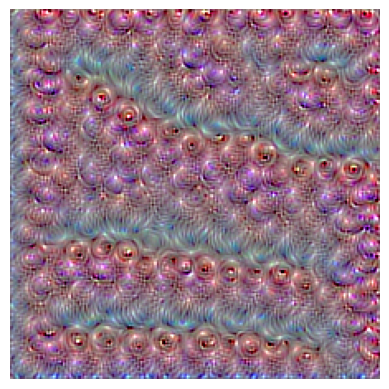

<Figure size 640x480 with 0 Axes>

In [227]:
fig = plt.imshow(pattern_generated_main)
plt.axis('off')
plt.show()
plt.savefig('pattern_{}'.format(layer_name))

## Send Images of Varying Classes and track which most excites the chosen filter


* [Data Source](https://www.image-net.org/download.php)
* [Data Source Kaggle](https://www.kaggle.com/competitions/imagenet-object-localization-challenge/data)

In [57]:
train_dir = "/notebooks/Lab3/image_net_5_per_class"
train_files = [i for i in glob.glob(train_dir + "//*//*")]
rand.shuffle(train_files)

train_labels = [
    os.path.dirname(i).split("/")[-1] for i in train_files
]

train_df = pd.DataFrame(data = {"file_path": train_files, "classification": train_labels})
print("Training data description: \n{}".format(train_df.describe()))

Training data description: 
                                                file_path classification
count                                                5000           5000
unique                                               5000           1000
top     /notebooks/Lab3/image_net_5_per_class/n0250445...      n02504458
freq                                                    1              5


In [58]:
def get_out_per_class(dataset, model, processor, layer_name, filter_index,  samp_num=2, size=(224,224)):
    # Build a model that outputs the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    # Isolate the output 
    new_model = models.Model(inputs=model.input, outputs=layer_output)
    
    # We start from a gray image with some uniform noise
    # input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    res = {}
    res['class'] = []
    res['result'] = []
    res['label'] = []
    for class_type in train_df['classification'].unique():
        
        image_paths = train_df.loc[train_df['classification'] == class_type]['file_path'].sample(n=samp_num)
        filter_outputs = np.empty(samp_num)
        for idx, image_path in enumerate(image_paths):
            img = load_image_as_array(image_path, size=size, local_path=True)
            x = np.expand_dims(img, axis=0)
            I_start = tf.Variable(x , name='image_var', dtype = 'float64')
            I = processor(I_start) # only process once
            model_vals = new_model(I) 
            filter_output = tf.reduce_mean(model_vals[:, :, :, filter_index])
            filter_outputs[idx] = filter_output.numpy()
        res['class'].append(class_type)
        res['label'].append(labels_df.loc[labels_df['class'] == class_type].label.item())
        res['result'].append(np.mean(filter_outputs))
    return pd.DataFrame(res)

In [59]:
%%time
result = get_out_per_class(
    dataset = train_df,
    model = vgg19_model,
    processor = preprocess_input,
    layer_name = layer_name,
    filter_index = filter_index
)

CPU times: user 22.5 s, sys: 295 ms, total: 22.8 s
Wall time: 23 s


Text(0, 0.5, 'mean output')

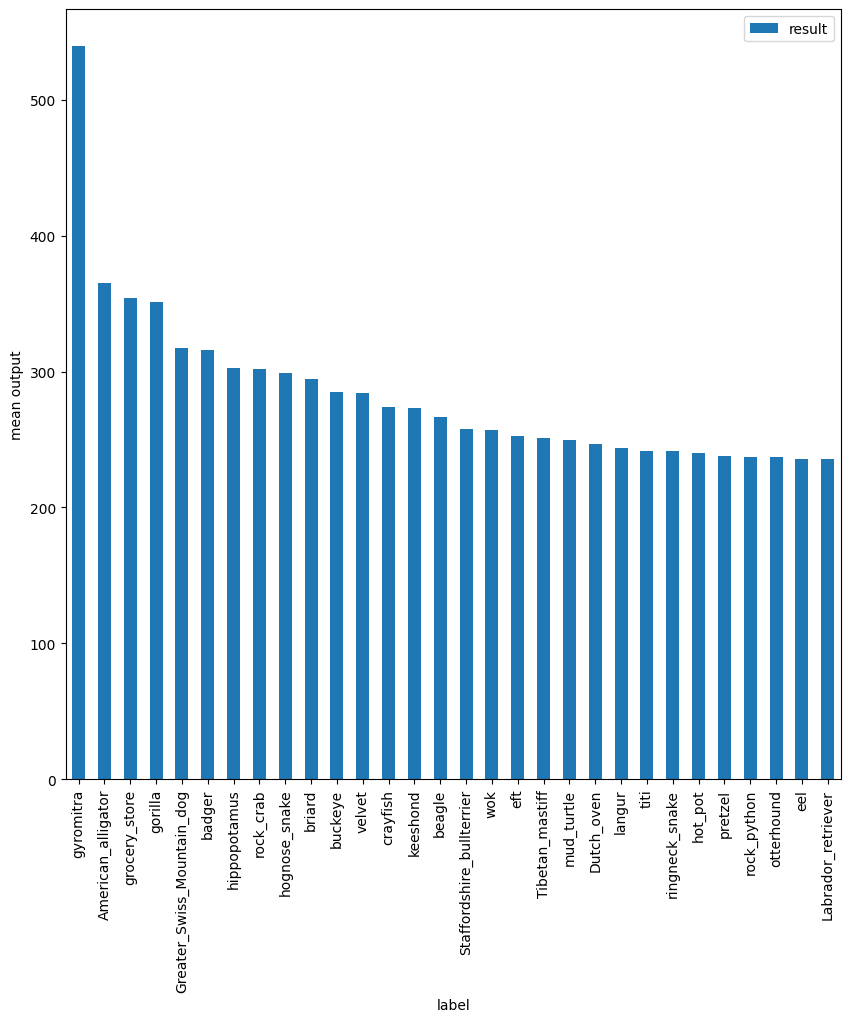

In [60]:
result.nlargest(30, 'result').plot('label','result', kind='bar', figsize=(10,10))
plt.xlabel('label')
plt.ylabel('mean output')

## Hypothesis for What the chosen filter might be extracting

**Give reasoning**

# Analyzing Each Channel of the multi-channel filter - How it might form a circuit ?

In [189]:
base_filters, _ = vgg19_model.get_layer(layer_name).get_weights()


In [62]:
filters, _ = vgg19_model.get_layer(previous_layer_name).get_weights()
x = {}
for filterNum in range(filters.shape[3]):
    x[filterNum] = LA.norm(filters[:,:,:,filterNum])
top_filters = dict(sorted(x.items(), key=itemgetter(1), reverse=True)[:10])

In [64]:
top_channels_per_filter = {}
for top_filter in top_filters:
    y = {}
    for channel in range(filters.shape[2]):
        y[channel] = LA.norm(filters[:,:,channel,top_filter])
    top_channels = dict(sorted(y.items(), key=itemgetter(1), reverse=True)[:3]).keys()
    top_channels_per_filter[top_filter] = top_channels

In [ ]:
H = lambda S : int(S, 16)/255.
C = lambda X: np.asarray([H(X[0:2]), H(X[2:4]), H(X[4:6])])

def weight_color_scale(x):
    threshold=0.1
    if x < 0:
        x = -x
        if x < threshold:
            x = x*2
            return (1-x)*C("f7f7f7") + x*C("1a1aff")
        else:
            x = (x-threshold)*2
            return (1-x)*C("1a1aff") + x*C("000033")
    else:
        if x < threshold:
            x = x*2
            return (1-x)*C("f7f7f7") + x*C("b30000")
        else:
            x = (x-threshold)*2
            return (1-x)*C("b30000") + x*C("1a0000")

weight_heatmap = lambda X: np.asarray([[weight_color_scale(x) for x in X_] for X_ in X])

In [260]:
def plot_relation_filters(top_filter, top_channels_per_filter_dict, prev_layer_filters, f_idx_under_examine, base_filters):
    # Visualize Top Channels per filter to the filter under study
    fig = plt.figure(figsize=(10,10))
    gs0 = gridspec.GridSpec(1, 3, figure=fig, hspace=0.0,wspace=0.1)
    gs00 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[0], hspace=0.1,wspace=0.1)
    t = None
    for c_idx, top_channel in enumerate(top_channels_per_filter_dict[top_filter]):
        im = weight_heatmap(prev_layer_filters[:,:,top_channel,top_filter])
        ax = fig.add_subplot(gs00[c_idx])
        if (c_idx == 0):
            t = ax
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('L[{}]F[{}]Ch:[{}]Avg[{:5.4f}]'.format(previous_layer_name, top_filter, top_channel, np.average(prev_layer_filters[:,:,top_channel,top_filter])))
        ax.title.set_size(8)

    gs01 = gs0[1].subgridspec(1, 1)

    axs = fig.add_subplot(gs01[-1, -1])
    im_pattern = generate_pattern(
        model = vgg19_model,
        processor = preprocess_input,
        layer_name = previous_layer_name,
        filter_index = top_filter,
        epochs=40
    )

    axs.imshow(im_pattern)
    axs.set_xticks([])
    axs.set_yticks([])
    axs.set_title('L[{}]F[{}]Avg[{:5.4f}]'.format(previous_layer_name, top_filter, np.average(prev_layer_filters[:,:,:,top_filter])))
    axs.title.set_size(10)
    d = axs

    gs02 = gs0[2].subgridspec(1, 1)

    axs = fig.add_subplot(gs02[-1, -1])
    axs.imshow(pattern_generated_main)
    axs.set_xticks([])
    axs.set_yticks([])
    axs.set_title('L[{}]F[{}]Avg[{:5.4f}]'.format(layer_name, filter_index, np.average(base_filters[:,:,:,f_idx_under_examine])))
    axs.title.set_size(10)

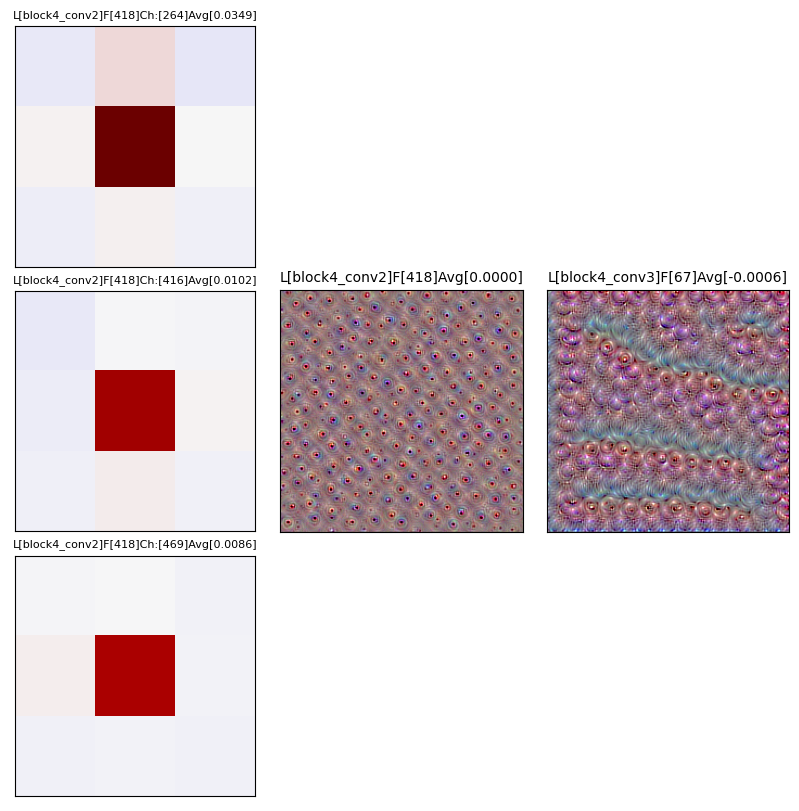

In [253]:
plot_relation_filters(
    top_filter = list(top_filters.keys())[0],
    top_channels_per_filter_dict = top_channels_per_filter,
    prev_layer_filters = filters,
    f_idx_under_examine = filter_index,
    base_filters = base_filters
)

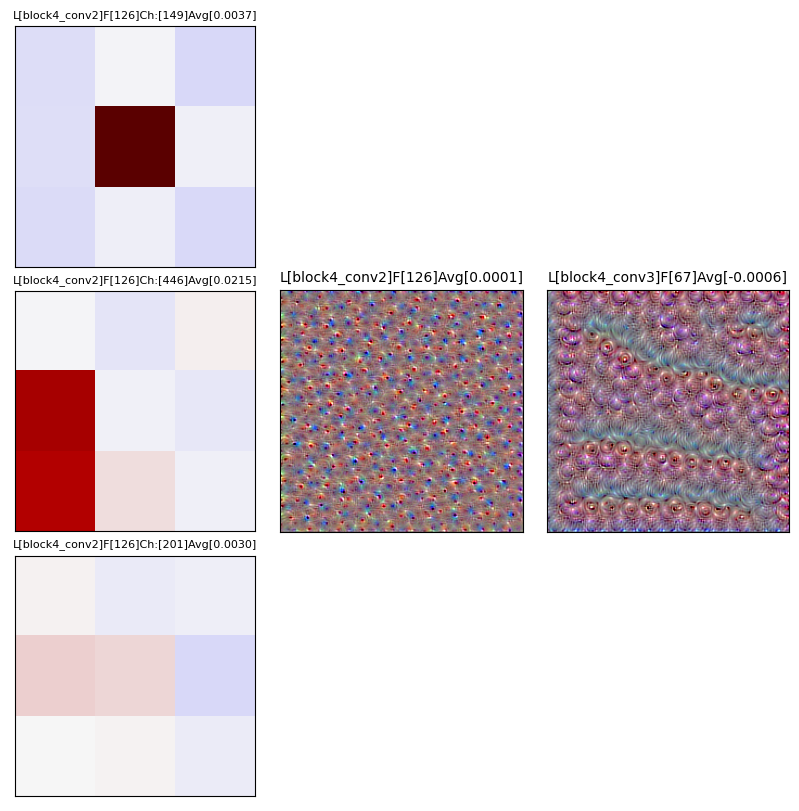

In [254]:
plot_relation_filters(
    top_filter = list(top_filters.keys())[1],
    top_channels_per_filter_dict = top_channels_per_filter,
    prev_layer_filters = filters,
    f_idx_under_examine = filter_index,
    base_filters = base_filters
)


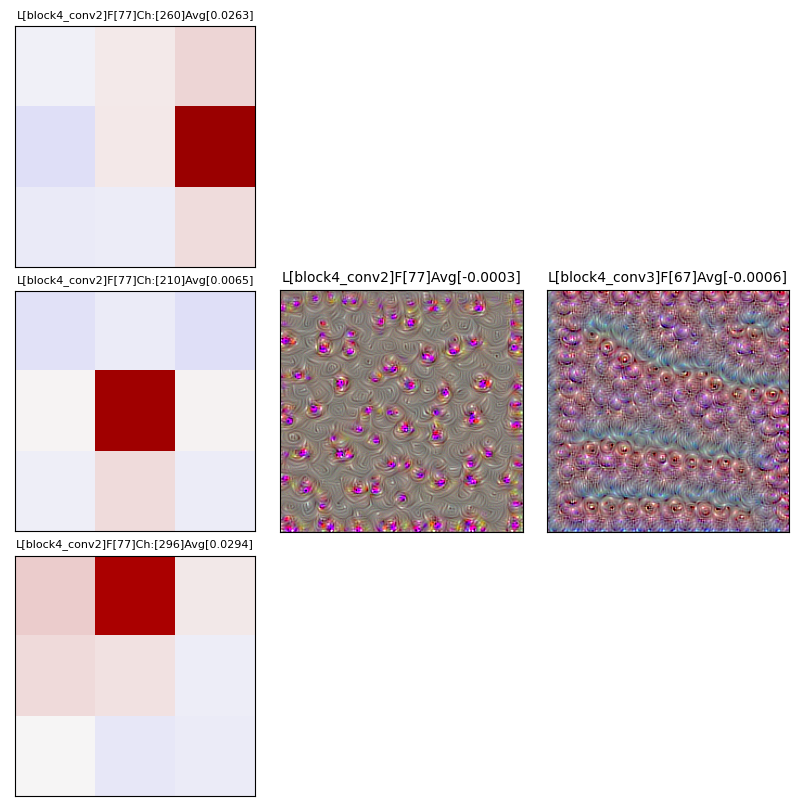

In [255]:
plot_relation_filters(
    top_filter = list(top_filters.keys())[2],
    top_channels_per_filter_dict = top_channels_per_filter,
    prev_layer_filters = filters,
    f_idx_under_examine = filter_index,
    base_filters = base_filters
)

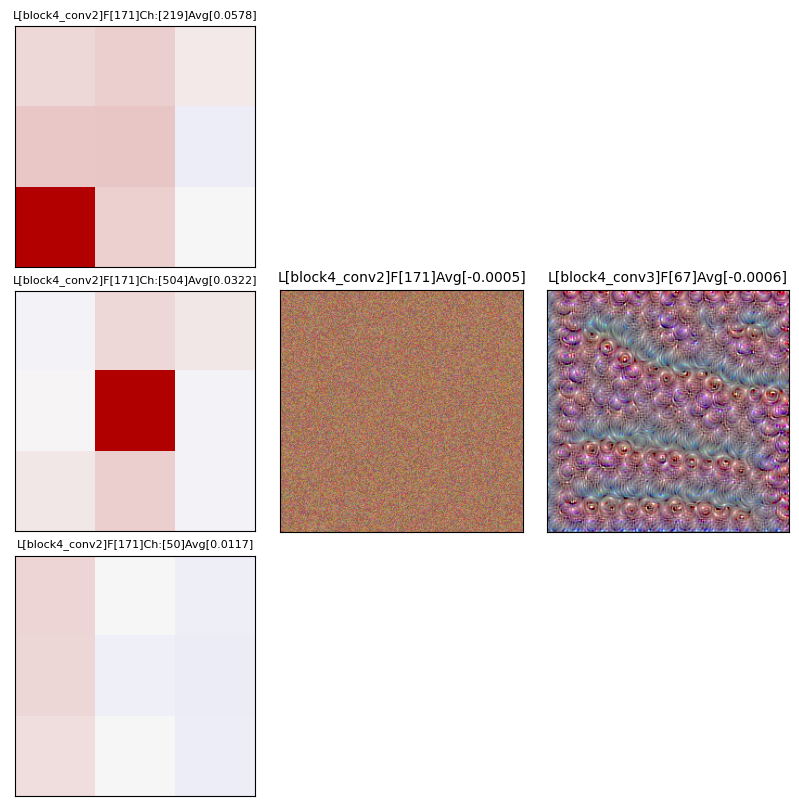

In [256]:
plot_relation_filters(
    top_filter = list(top_filters.keys())[3],
    top_channels_per_filter_dict = top_channels_per_filter,
    prev_layer_filters = filters,
    f_idx_under_examine = filter_index,
    base_filters = base_filters
)

In [ ]:
plot_relation_filters(
    top_filter = list(top_filters.keys())[4],
    top_channels_per_filter_dict = top_channels_per_filter,
    prev_layer_filters = filters,
    f_idx_under_examine = filter_index,
    base_filters = base_filters
)

In [ ]:
plot_relation_filters(
    top_filter = list(top_filters.keys())[5],
    top_channels_per_filter_dict = top_channels_per_filter,
    prev_layer_filters = filters,
    f_idx_under_examine = filter_index,
    base_filters = base_filters
)

In [ ]:
plot_relation_filters(
    top_filter = list(top_filters.keys())[6],
    top_channels_per_filter_dict = top_channels_per_filter,
    prev_layer_filters = filters,
    f_idx_under_examine = filter_index,
    base_filters = base_filters
)

In [ ]:
plot_relation_filters(
    top_filter = list(top_filters.keys())[7],
    top_channels_per_filter_dict = top_channels_per_filter,
    prev_layer_filters = filters,
    f_idx_under_examine = filter_index,
    base_filters = base_filters
)

In [ ]:
plot_relation_filters(
    top_filter = list(top_filters.keys())[8],
    top_channels_per_filter_dict = top_channels_per_filter,
    prev_layer_filters = filters,
    f_idx_under_examine = filter_index,
    base_filters = base_filters
)

In [ ]:
plot_relation_filters(
    top_filter = list(top_filters.keys())[9],
    top_channels_per_filter_dict = top_channels_per_filter,
    prev_layer_filters = filters,
    f_idx_under_examine = filter_index,
    base_filters = base_filters
)

In [ ]:
plot_relation_filters(
    top_filter = list(top_filters.keys())[10],
    top_channels_per_filter_dict = top_channels_per_filter,
    prev_layer_filters = filters,
    f_idx_under_examine = filter_index,
    base_filters = base_filters
)

In [271]:
def plot_relation_filters_2(top_filter_dict, prev_layer_filters, f_idx_under_examine, base_filters):
    # Visualize Top Channels per filter to the filter under study
    fig = plt.figure(figsize=(10,10))
    gs0 = gridspec.GridSpec(1, 2, figure=fig, hspace=0.0,wspace=0.1)
    gs00 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[0], hspace=0.1,wspace=0.1)
    t = None
    for filter_idx, top_filter in enumerate(top_filter_dict):
        im_pattern = generate_pattern(
            model = vgg19_model,
            processor = preprocess_input,
            layer_name = previous_layer_name,
            filter_index = filter_idx,
            epochs=40
        )
        ax = fig.add_subplot(gs00[filter_idx])
        if (c_idx == 0):
            t = ax
        ax.imshow(im_pattern)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('L[{}]F[{}]Ch:[{}]Avg[{:5.4f}]'.format(previous_layer_name, top_filter, top_channel, np.average(prev_layer_filters[:,:,:,top_filter])))
        ax.title.set_size(8)

    gs01 = gs0[1].subgridspec(1, 1)

    axs = fig.add_subplot(gs01[-1, -1])

    axs.imshow(pattern_generated_main)
    axs.set_xticks([])
    axs.set_yticks([])
    axs.set_title('L[{}]F[{}]Avg[{:5.4f}]'.format(layer_name, filter_index, np.average(base_filters[:,:,:,f_idx_under_examine])))
    axs.title.set_size(10)

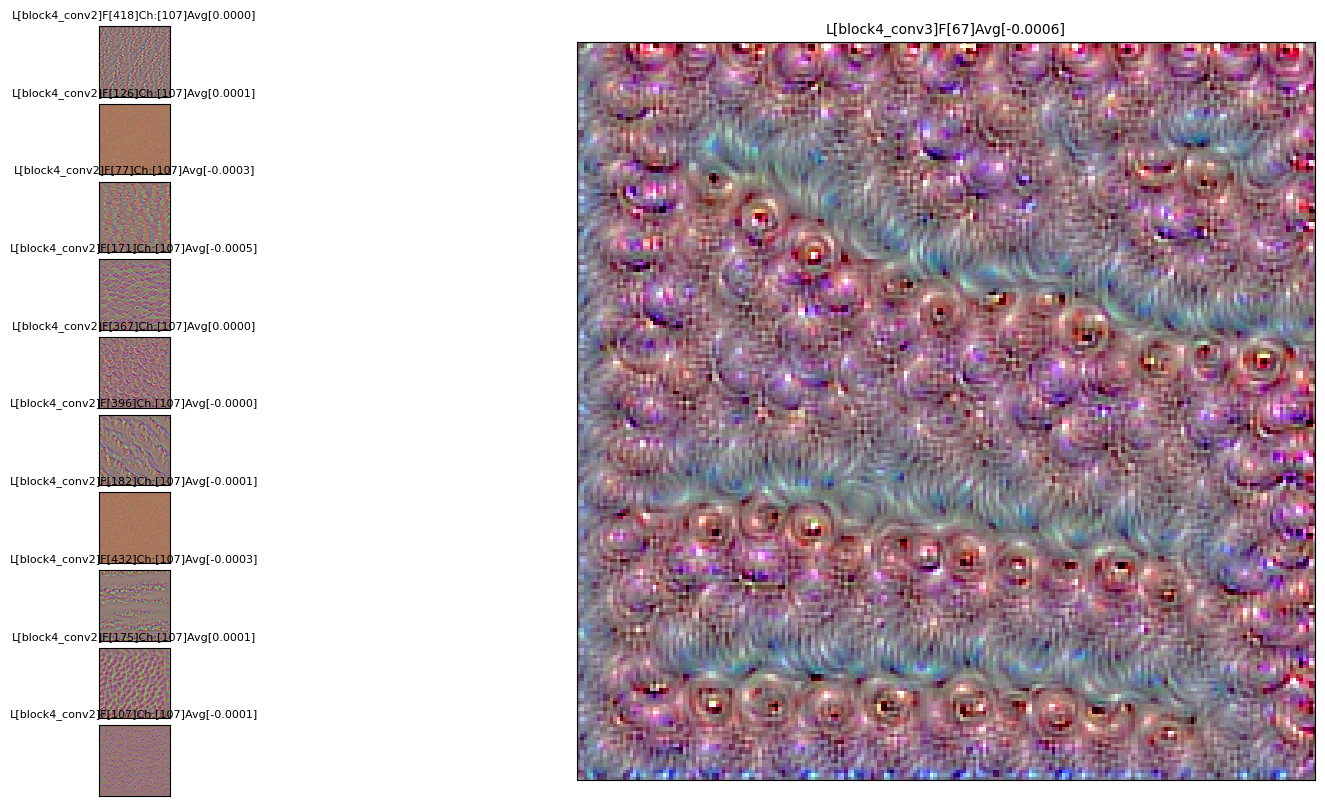

In [ ]:
plot_relation_filters_2(
    top_filter_dict = top_filters,
    prev_layer_filters = filters,
    f_idx_under_examine = filter_index,
    base_filters = base_filters
)
